# Homework 2
## Eric Schulman

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

In [2]:
wage1 = pd.read_stata('Homework/WAGE1.DTA')

We use the Nadarya Watson Kernel estimator with the Gaussian kernel and Silverman bandwidth $h = 1.06 \hat{\sigma} n^{-1/5}$

$\hat{m}(z) = \dfrac{\hat{\phi}(z)}{\hat{f}_z} = \dfrac{\sum_i Y_i K(\frac{z-Z_i}{h})}{\sum_i K(\frac{z-Z_i}{h})}$

Since, gender is discrete we can simply use an indicator function in its place of a kernel.

In [3]:
labels = ['educ','exper','female']
print labels[2:]+labels[:2]

['female', 'educ', 'exper']


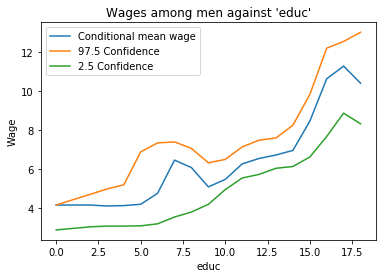

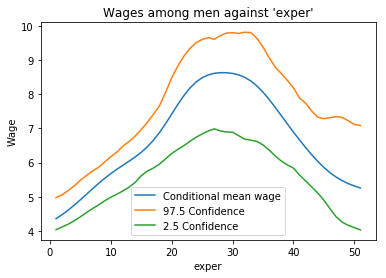

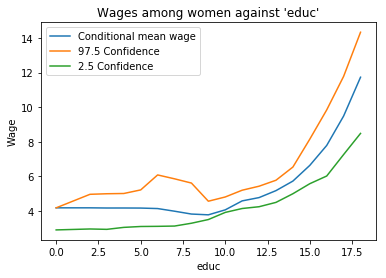

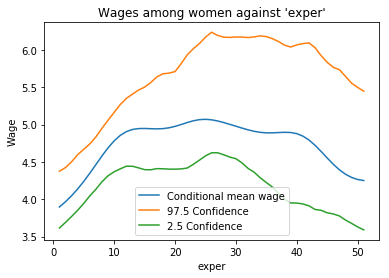

In [4]:
#fit overall model
sigma = wage1.std()[['educ','exper','female']]
nobs = wage1.shape[0]
bands = 1.06*sigma*nobs**(-(1./5.))

model = sm.nonparametric.KernelReg(wage1['wage'],wage1[['educ','exper','female']], ['c','c','u'], 
                                   bw=bands ,reg_type='lc')

mu = wage1.mean()[['educ','exper']]


#boot strap 100 samples of 200 observations
for gender in [0,1]:
    for x  in ['educ','exper']:
        
        #pull data from array and sort for graphing
        data = np.array(wage1[x].copy().unique())
        data.sort()
        
        #set up data (constant values) for graphing in 2d
        const = mu.copy()
        const['female'] = gender
        const = np.repeat(const,len(data))
        const[x] = data
        const = np.array(const).reshape(3,len(data))
        
        #fit kernel regression for graphing purposes
        y = model.fit(const)
        
        #graph result of kernel regression
        title = "Wages among men against '%s'"%x
        if gender: title = "Wages among women against '%s'"%x
        plt.title(title)
        plt.plot(data, y[0], label = 'Conditional mean wage')
        
        #run bootstrap
        bootstrap = []
    
        for i in range(100):
            #draw subsample
            subn = 200
            sample = np.random.choice(np.arange(0,nobs), subn , replace=False)
            sample = wage1.iloc[sample]
        
            #compute bands
            sub_sigma = sample.std()[['educ','exper','female']]
            sub_bands = 1.06*sub_sigma*subn**(-(1./5.))
    
            #re run the model
            boot_model = sm.nonparametric.KernelReg(sample['wage'],sample[['educ','exper','female']],
                                               ['c','c','u'], bw=sub_bands ,reg_type='lc')
            boot_y = boot_model.fit(const)[0]
            bootstrap.append(boot_y)
    
        bootstrap = np.array(bootstrap)

        #plot upper bound
        bootstrap_l = np.percentile(bootstrap , 97.5,axis=0)
        plt.plot(data, bootstrap_l, label='97.5 Confidence')
    
        #plot lower bound
        bootstrap_u = np.percentile(bootstrap , 2.5,axis=0)
        plt.plot(data, bootstrap_u, label='2.5 Confidence')
    
        plt.ylabel('Wage')
        plt.xlabel(x)
        plt.legend()
        plt.show()
    